In [3]:
!date

Wed Jan 15 11:20:03 PST 2020


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import anndata
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
from kb_python.utils import import_matrix_as_anndata
from scipy.sparse import csr_matrix
from scipy.io import mmread, mmwrite
#from matplotlib_venn import venn3
from sklearn.metrics import adjusted_rand_score
from scipy import stats
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches

plt.rcParams.update({'font.size': 18})

%config InlineBackend.figure_format = 'retina'

In [4]:
fsize = 20
gridalpha = 0.2

def knee_plot(mtx, ax=None, **kwargs):
    '''
        Makes knee plot.
        A: adata
        kwargs: [c = _lighten_color(B_color, 0.5), linewidth=2, alpha=1]
    '''
    ax = ax or plt.gca()

    ranked_umi = np.sort(mtx, axis=None)[::-1] # reversed
    ax.plot(ranked_umi, np.arange(len(ranked_umi)), **kwargs)
    return ax

def knee_plot_settings(mtx, ax=None):
    ax = ax or plt.gca()
    
    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_yscale("log", nonposy='clip')
    ax.set_xlabel('UMI counts',fontsize=fsize)
    ax.set_ylabel('Cumulative number of barcodes',fontsize=fsize)
    ax.set_title('',loc='center')
    #ax.set_title('A', fontweight='bold', fontsize = fsize, loc = 'left' )
    ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = gridalpha)


    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1])
    return ax

def plot_embedding(Y, comp=[0,1], labels=None, ax=None, plot_label=None, ax_label=None):
    x = Y[:,comp[0]]
    y = Y[:,comp[1]]

    ax = ax or plt.gca()

    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("{}1".format(ax_label))
    ax.set_ylabel("{}2".format(ax_label))
    if plot_label is None:
        plot_label = ""
        
    if ax_label is None:
        ax_label = ""

    if labels is not None:
        ax.scatter(x,y, c=labels, cmap="tab20b", label=plot_label)
        ax.legend(markerscale = 0)
        return ax
    ax.scatter(x,y, color="black")
    return ax

def plot_bulk(X, Y, xlabel=None, ylabel=None, ax=None):
    ax = ax or plt.gca()
    
    ax.set_xlim((10, 10**6))
    ax.set_ylim((10, 10**6))
    ax.set_xlabel(xlabel, fontsize=fsize)
    ax.set_ylabel(ylabel, fontsize=fsize)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_yscale("log", nonposy='clip')
    
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    
    
    ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = gridalpha)
    
    ax.scatter(X, Y, c="black", s=10, alpha=0.2)

    return ax

def _sparse_M_std(X):
    n = X.shape[0]
    return np.sqrt(n * X.multiply(X).sum(0) - np.multiply(X.sum(0), X.sum(0)))

def sparse_M_corr(X, Y):
    '''
        Computes Pearson correlation between X and Y (both in sparse format). Must be same shape.
        X: A_raw[common_obs.index].layers['log1p'] # raw
        Y: B_raw[common_obs.index].layers['log1p']# raw
        X: A.layers['log1p'] # filtered
        Y: B.layers['log1p'] # filtered
        Notes: I changed the axis in sum and shape, need to check if right
    '''
    X_std = _sparse_M_std(X)
    Y_std = _sparse_M_std(Y)
    XY_std = np.multiply(X_std, Y_std)
    n = X.shape[0]
    XY_cov = n*X.multiply(Y).sum(0) - np.multiply(X.sum(0), Y.sum(0))
    R = np.divide(XY_cov, XY_std)
    return np.squeeze(np.asarray(R))

def corr_plot(X, Y, xlabel=None, ax=None, leg=None):
    ax = ax or plt.gca()

    ax.set_xscale('log')
    ax.set_xlim(1,10**6)
    ax.set_ylim(0,1)
    ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = gridalpha)
    ax.set_xlabel(xlabel, fontsize = fsize)
    ax.set_ylabel('Pearson Correlation', fontsize = fsize)
    handles, labels = ax.get_legend_handles_labels()
    #ax.legend(handles[::-1], labels[::-1])

    ax.scatter(X, Y, c="black", s=10, alpha=0.2, label=leg[0]+" vs. "+leg[1])
    ax.legend()
    return ax

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar=0
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

# Load kite data

In [5]:
samples = 138
random_state = 42

In [6]:
raw = anndata.read_h5ad("/home/sina/projects/kite/perturb-seq/kite_out/all/counts_unfiltered/adata.h5ad")
print(raw)
raw.obs["counts"] = raw.X.sum(1)
raw.obs["num_nonzero"] = (raw.X>0).sum(1)
raw = raw[raw.obs["counts"]>0]

mtx = raw.X.todense()
raw.layers["norm"] = (mtx/raw.obs["counts"].values[:,None])*1000

AnnData object with n_obs × n_vars = 70117 × 138 


In [7]:
kite = raw[raw.obs["counts"].nlargest(500000).index.values]
print(kite)

View of AnnData object with n_obs × n_vars = 61936 × 138 
    obs: 'counts', 'num_nonzero'
    layers: 'norm'


# Load barcode map gRNA map

In [56]:
map_bcs = pd.read_csv("/home/sina/projects/kite/perturb-seq/geo/GSE132080_cell_identities.csv")

In [57]:
map_bcs.index = map_bcs.cell_barcode.str.slice(0, 16)

In [53]:
map_bcs["guide_identity"] = map_bcs["guide_identity"].apply(lambda s: "_".join(s.split("_")[1:]))

/home/sina/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [62]:
def remove_bad_dudes(s):
    g = "_".join(s.split("_")[1:])
    if "ctrl" in g:
        g = "_".join(g.split("_")[1:])
    return g

In [66]:
map_bcs["guide_identity"] = map_bcs.guide_identity.apply(remove_bad_dudes).values

In [67]:
map_bcs = map_bcs.loc[~map_bcs.index.duplicated(keep='first')]

In [68]:
map_bcs

,cell_barcode,guide_identity,read_count,UMI_count,coverage,gemgroup,good_coverage,number_of_cells
cell_barcode,,,,,,,,
GGACAAGTCCCTGACT,GGACAAGTCCCTGACT-3,non-targeting_00028,7452,457,16.306346,3,True,1
CGACTTCAGAAGGCCT,CGACTTCAGAAGGCCT-3,GNB2L1_+_180670873.23-P1P2_13,6554,361,18.155125,3,True,1
TTAGGCAAGAAGGCCT,TTAGGCAAGAAGGCCT-2,TUBB_+_30688126.23-P1_00,4177,165,25.315152,2,True,2
CGTAGGCAGCCAGGAT,CGTAGGCAGCCAGGAT-1,TUBB_+_30688126.23-P1_01,4024,218,18.458716,1,True,1
GCGCAACTCACGATGT,GCGCAACTCACGATGT-2,HSPE1_+_198365089.23-P1P2_00,3923,134,29.276119,2,True,1
...,...,...,...,...,...,...,...,...
TGGTTCCCATGTAAGA,TGGTTCCCATGTAAGA-2,EIF2S1_-_67827080.23-P1P2_06,1,1,1.000000,2,False,0
TGTGGTAAGACAATAC,TGTGGTAAGACAATAC-1,RPS15_-_1438413.23-P1P2_12,1,1,1.000000,1,False,0
TGTTCCGAGGCTACGA,TGTTCCGAGGCTACGA-1,DUT_+_48624411.23-P1P2_00,1,1,1.000000,1,False,0


In [69]:
from sklearn.metrics import adjusted_rand_score

In [70]:
common = np.intersect1d(kite.obs.index.values, map_bcs.index.values)

In [71]:
common.shape

(23176,)

In [72]:
kite = kite[common]

### Perform kmeans, PCA, TSNE, UMAP on kite

In [36]:
kmeans = KMeans(n_clusters=samples+1, random_state=random_state, init='k-means++')
pca = pca = PCA(n_components=2, random_state=random_state)
tsne = TSNE(random_state=random_state)
umap = UMAP(random_state=random_state)

In [37]:
%%time
kmeans.fit(kite.layers["norm"])
YY_pca = pca.fit_transform(kite.layers["norm"])
YY_tsne = tsne.fit_transform(kite.layers["norm"])
YY_umap = umap.fit_transform(kite.layers["norm"])

/home/sina/miniconda3/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../miniconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


CPU times: user 3h 37min 12s, sys: 6min 38s, total: 3h 43min 51s
Wall time: 4min 51s


In [38]:
kite.obs["kmeans"] = kmeans.labels_

kite.obs["PCA0"] = YY_pca[:,0]
kite.obs["PCA1"] = YY_pca[:,1]

kite.obs["TSNE0"] = YY_tsne[:,0]
kite.obs["TSNE1"] = YY_tsne[:,1]

kite.obs["UMAP0"] = YY_umap[:,0]
kite.obs["UMAP1"] = YY_umap[:,1]


Trying to set attribute `.obs` of view, making a copy.


In [39]:
kite.obs.head()

,counts,num_nonzero,kmeans,PCA0,PCA1,TSNE0,TSNE1,UMAP0,UMAP1,max,assign
index,,,,,,,,,,,
AAACCTGAGAGCAATT,20.0,4,12,-29.296878,-18.929589,25.430979,-52.199646,6.603342,1.748333,32,RAN_+_131356438.23-P1P2_02
AAACCTGAGAGTAATC,35.0,4,16,-31.141488,-36.193479,-42.316620,17.922916,7.706300,-2.403034,35,RAN_+_131356438.23-P1P2_12
AAACCTGAGCTAAGAT,14.0,4,39,-22.550262,-17.475466,-27.667295,-38.163975,2.270154,-10.400996,63,CDC23_-_137548987.23-P1P2_08
AAACCTGAGGGATCTG,19.0,1,64,-30.229304,-22.904608,12.442214,68.492378,7.856020,-10.443789,131,non-targeting_00089
AAACCTGAGGTCATCT,33.0,4,108,-19.803373,-14.949751,-32.754478,65.989708,0.639756,16.183315,83,POLR2H_+_184081251.23-P1P2_08


In [40]:
kite.X[0].todense()

matrix([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0., 17.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]], dtype=float32)

Save assignments

In [73]:
mtx = kite.X.todense()

In [74]:
kite.obs["max"] = np.asarray(np.argmax(mtx, axis=1))[:,0]
kite.obs["assign"] = kite.var.index.values[kite.obs["max"].values]

Trying to set attribute `.obs` of view, making a copy.


In [75]:
adjusted_rand_score(kite[common].obs["assign"].values, map_bcs[map_bcs.index.isin(common)].guide_identity.values)

7.286167302266713e-05

In [76]:
map_bcs["guide_identity"].value_counts()

GNB2L1_+_180670873.23-P1P2_08    581
DUT_+_48624411.23-P1P2_01        450
MTOR_+_11322547.23-P1P2_00       404
POLR1D_+_28196016.23-P1_07       397
DBR1_+_137893744.23-P1P2_00      365
                                ... 
RPS14_+_149829238.23-P1P2_01      69
GATA1_-_48645022.23-P1P2_00       55
GATA1_-_48645022.23-P1P2_04       52
GINS1_-_25388381.23-P1P2_00       48
GNB2L1_+_180670873.23-P1P2_00     33
Name: guide_identity, Length: 139, dtype: int64

In [77]:
kite.obs["assign"].value_counts().head()

GNB2L1_+_180670873.23-P1P2_08    695
POLR1D_+_28196016.23-P1_07       581
DUT_+_48624411.23-P1P2_01        466
CDC23_-_137548987.23-P1P2_11     446
POLR1D_+_28196016.23-P1_08       367
Name: assign, dtype: int64

In [52]:
kite.obs["assign"].unique()

array(['RAN_+_131356438.23-P1P2_02', 'RAN_+_131356438.23-P1P2_12',
       'CDC23_-_137548987.23-P1P2_08', 'non-targeting_00089',
       'POLR2H_+_184081251.23-P1P2_08', 'non-targeting_00028',
       'ATP5E_-_57607036.23-P1P2_14', 'POLR1D_+_28196016.23-P1_08',
       'CAD_+_27440280.23-P1P2_13', 'TUBB_+_30688126.23-P1_03',
       'TUBB_+_30688126.23-P1_01', 'COX11_+_53045977.23-P1P2_03',
       'CDC23_-_137548987.23-P1P2_04', 'GNB2L1_+_180670873.23-P1P2_02',
       'CDC23_-_137548987.23-P1P2_02', 'DUT_+_48624411.23-P1P2_01',
       'CDC23_-_137548987.23-P1P2_11', 'POLR1D_+_28196016.23-P1_07',
       'MTOR_+_11322547.23-P1P2_05', 'GATA1_-_48645022.23-P1P2_12',
       'non-targeting_00001', 'DUT_+_48624411.23-P1P2_08',
       'non-targeting_01040', 'POLR2H_+_184081251.23-P1P2_12',
       'POLR1D_+_28196016.23-P1_03', 'RPS18_+_33239917.23-P1P2_01',
       'DBR1_+_137893744.23-P1P2_01', 'GINS1_-_25388381.23-P1P2_08',
       'RAN_+_131356438.23-P1P2_04', 'RPS14_+_149829238.23-P1P2_13',
     

In [66]:
kite.obs["max"].values

array([68,  7, 88, ..., 40, 67, 85])

In [67]:
kite.var.iloc[68]

Series([], Name: m_Rel_3, dtype: float64)

# Jaccard similarities between technologies

In [42]:
import itertools

In [49]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

In [50]:
jaccard_1 = np.zeros((samples + 1, samples + 1))
jaccard_2 = np.zeros((samples + 1, samples + 1))
jaccard_3 = np.zeros((samples + 1, samples + 1))

In [51]:
kite_clusters = np.sort(kite.obs.kmeans.unique())
cite_clusters = np.sort(cite.obs.kmeans.unique())
#cr_clusters = np.sort(cr.obs.kmeans.unique())

In [60]:
#product('ABCD', repeat=2)
len(list(itertools.product(kite_clusters, repeat=2)))

81

In [63]:

for i, j in list(itertools.product(kite_clusters, repeat=2)):
    a = kite[kite.obs.kmeans == i].obs.index.values
    b = cite[cite.obs.kmeans == j].obs.index.values
    #c = cr[cr.obs.kmeans == j].obs.index.values

    #d = cr[cr.obs.kmeans == i].obs.index.values
    
    jaccard_1[i, j] = jaccard_similarity(a, b) # kite vs cite
    #jaccard_2[i, j] = jaccard_similarity(a, c) # kite vs cr
    #jaccard_3[i, j] = jaccard_similarity(d, b) # cr vs cite

# Data Visualizations

In [67]:
all_bcs = [kite.obs.index.values, cite.obs.index.values]#, cr.obs.index.values]

common_bcs = np.sort(np.array(list(set.intersection(*map(set,all_bcs)))))

In [68]:
cmp_kite = kite[kite.obs.index.isin(common_bcs)].obs.index.values
cmp_cite = cite[cite.obs.index.isin(common_bcs)].obs.index.values
#cmp_cr = cr[cr.obs.index.isin(common_bcs)].obs.index.values

## Compare kmeans clustering on the common barcodes

1.0 is perfect

In [70]:
print("kite vs cite: ", adjusted_rand_score(cmp_kite, cmp_cite))
#print("kite vs cr: ", adjusted_rand_score(cmp_kite, cmp_cr))
#print("cr  vs cite: ", adjusted_rand_score(cmp_cr, cmp_cite))

kite vs cite:  1.0


## Look at knee plot

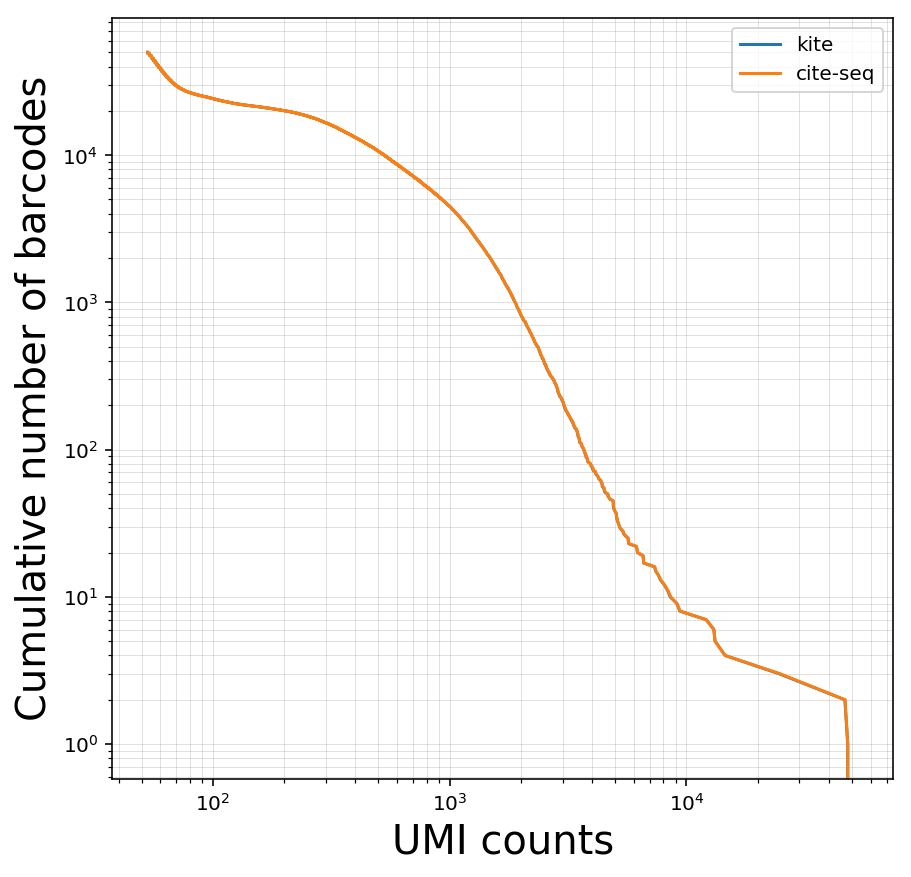

In [71]:
fig, ax = plt.subplots(figsize=(7, 7))

ax = knee_plot(kite.obs["counts"], ax, label="kite")
knee_plot_settings(kite.obs["counts"], ax)

ax = knee_plot(cite.obs["counts"], ax, label="cite-seq")
knee_plot_settings(cite.obs["counts"], ax)

# ax = knee_plot(cr.obs["counts"], ax, label="cell ranger")
# knee_plot_settings(cr.obs["counts"], ax)

plt.legend()

plt.show()

## How well do the barcodes overlap

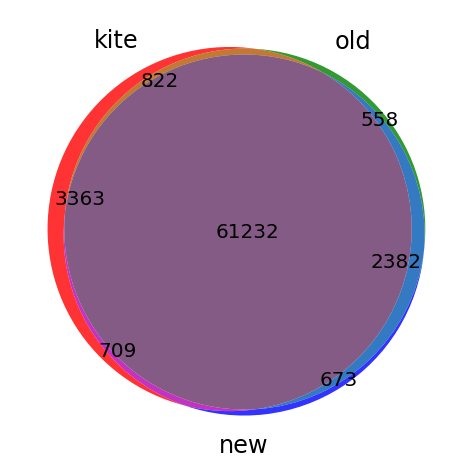

In [314]:
fig, ax = plt.subplots(figsize=(4,4))

set1 = set(kite.obs.index.values) # kite
set2 = set(cite.obs.index.values)
set3 = set(cr.obs.index.values)

venn3([set1, set2, set3], ('kite', 'cite', 'cr'), alpha=0.8)
plt.show()

## PCA on normalized counts

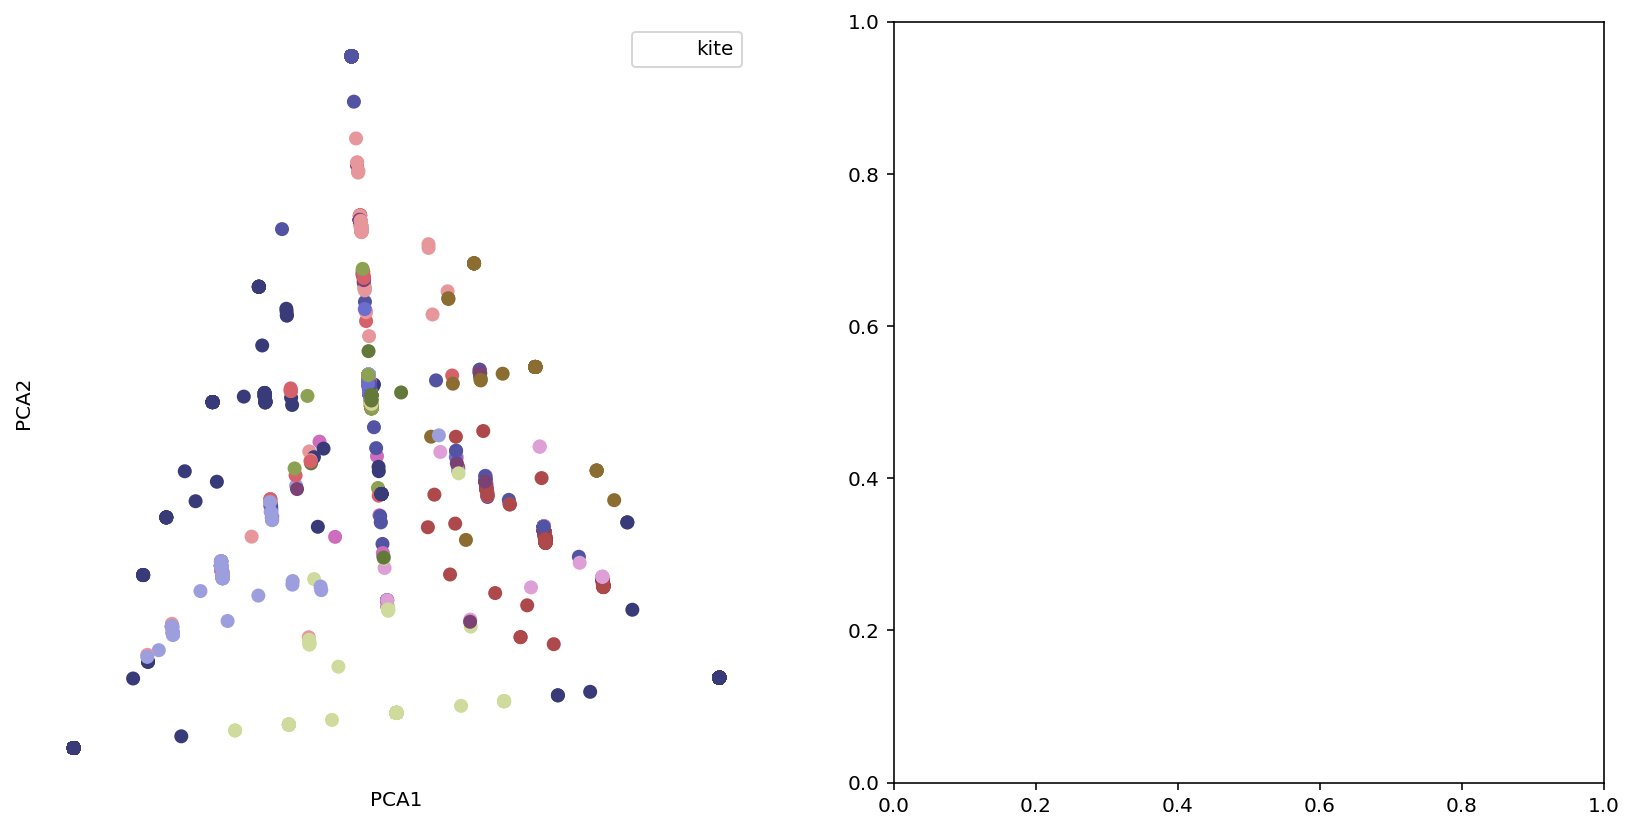

In [22]:
# fig, ax = plt.subplots(figsize=(7*3, 7), ncols=3)
fig, ax = plt.subplots(figsize=(7*2, 7), ncols=2)


plot_embedding(kite.obs.loc[:,"PCA0":"PCA1"].values, ax=ax[0], labels=kite.obs.loc[:,"kmeans"].values, plot_label="kite", ax_label="PCA")
#plot_embedding(cite.obs.loc[:,"PCA0":"PCA1"].values, ax=ax[1], labels=cite.obs.loc[:,"kmeans"].values, plot_label="cite-seq", ax_label="PCA")
#plot_embedding(cr.obs.loc[:,"PCA0":"PCA1"].values, ax=ax[2], labels=cr.obs.loc[:,"kmeans"].values, plot_label="cell ranger", ax_label="PCA")

plt.show()

## UMAP on normalized counts

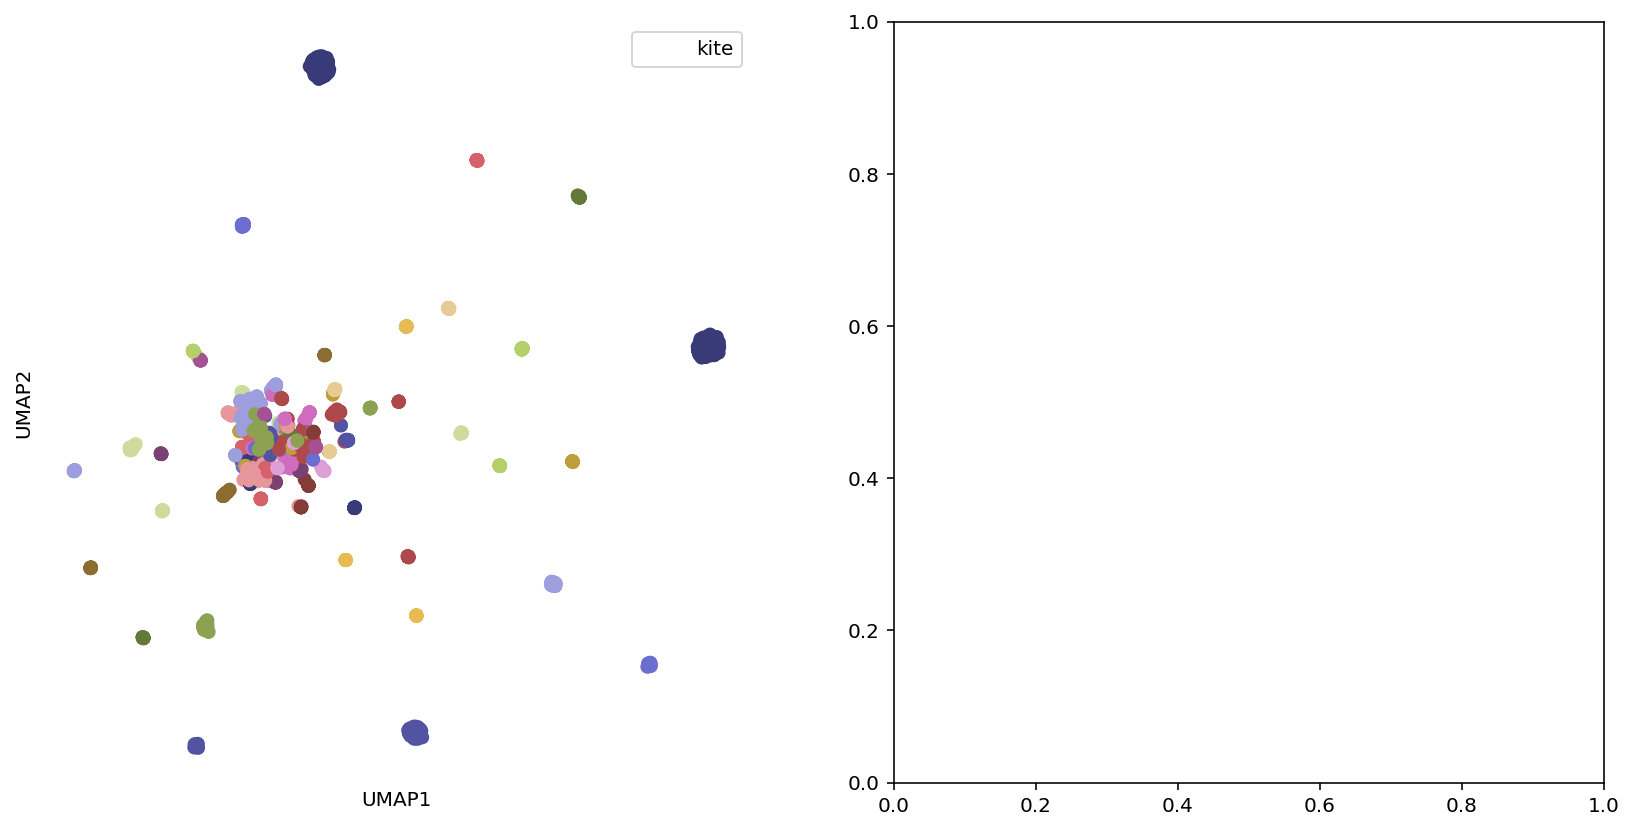

In [23]:
# fig, ax = plt.subplots(figsize=(7*3, 7), ncols=3)
fig, ax = plt.subplots(figsize=(7*2, 7), ncols=2)

plot_embedding(kite.obs.loc[:,"UMAP0":"UMAP1"].values, ax=ax[0], labels=kite.obs.loc[:,"kmeans"].values, plot_label="kite", ax_label="UMAP")
#plot_embedding(cite.obs.loc[:,"UMAP0":"UMAP1"].values, ax=ax[1], labels=cite.obs.loc[:,"kmeans"].values, plot_label="cite-seq", ax_label="UMAP")
#plot_embedding(cr.obs.loc[:,"UMAP0":"UMAP1"].values, ax=ax[2], labels=cr.obs.loc[:,"kmeans"].values, plot_label="cell ranger", ax_label="UMAP")

plt.show()

## tSNE on normalized counts

In [473]:
# plot the number of counts
# make colors discrete

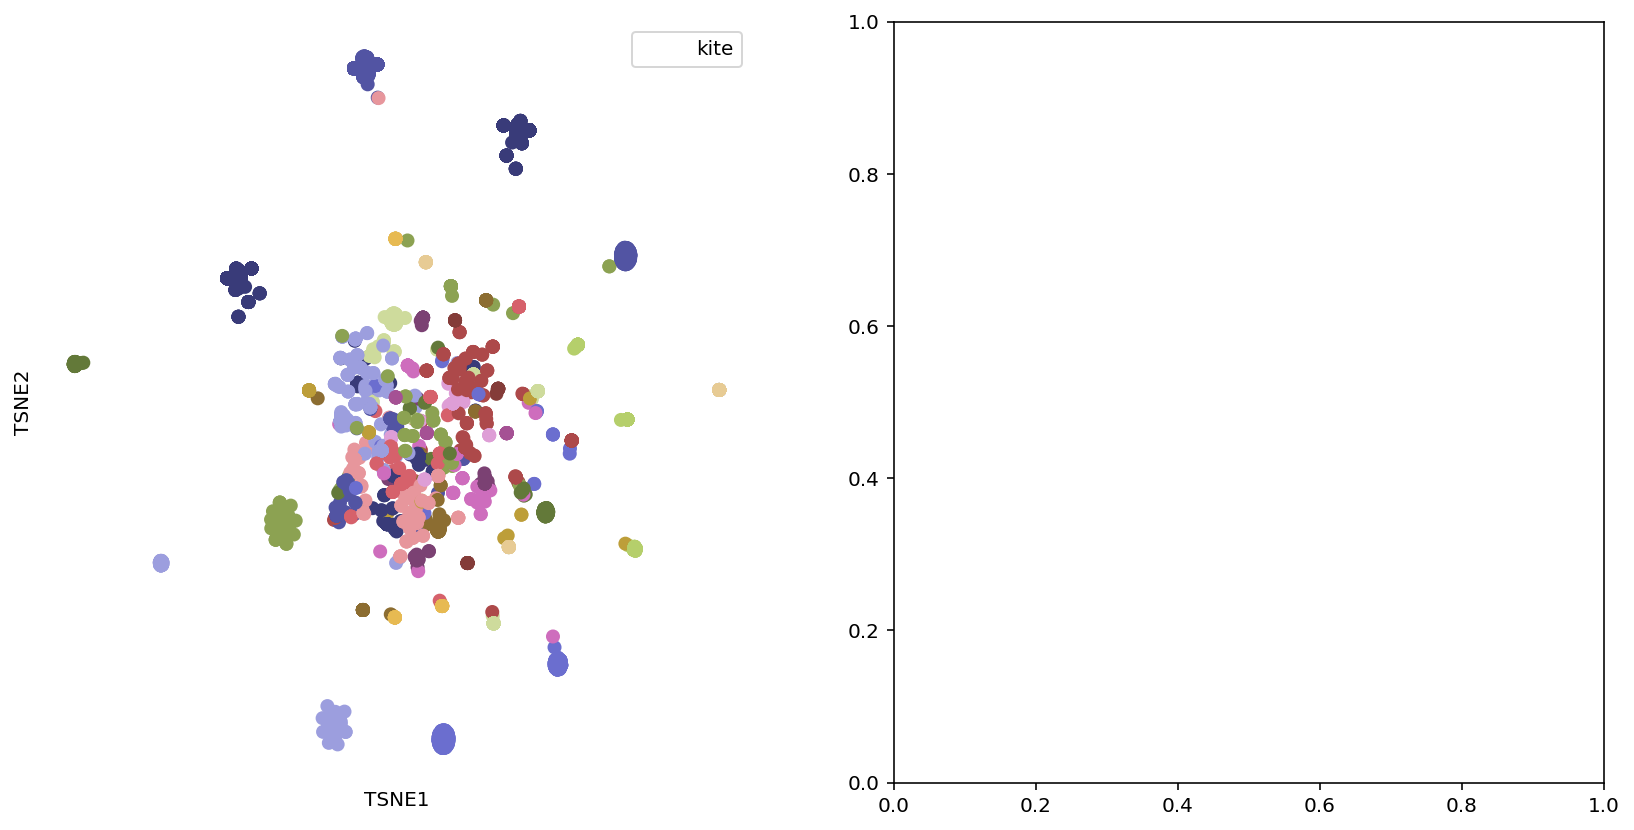

In [24]:
# fig, ax = plt.subplots(figsize=(7*3, 7), ncols=3)
fig, ax = plt.subplots(figsize=(7*2, 7), ncols=2)

plot_embedding(kite.obs.loc[:,"TSNE0":"TSNE1"].values, ax=ax[0], labels=kite.obs.loc[:,"kmeans"].values, plot_label="kite", ax_label="TSNE")
#plot_embedding(cite.obs.loc[:,"TSNE0":"TSNE1"].values, ax=ax[1], labels=cite.obs.loc[:,"kmeans"].values, plot_label="cite-seq", ax_label="TSNE")
# plot_embedding(cr.obs.loc[:,"TSNE0":"TSNE1"].values, ax=ax[2], labels=cr.obs.loc[:,"kmeans"].values, plot_label="cell ranger", ax_label="TSNE")

plt.show()

## Each dot is a cell, sum counts and compare

In [72]:
kite_bulk = kite[kite.obs.index.isin(common_bcs)].obs.counts
cite_bulk = cite[cite.obs.index.isin(common_bcs)].obs.counts
#cr_bulk = cr[cr.obs.index.isin(common_bcs)].obs.counts

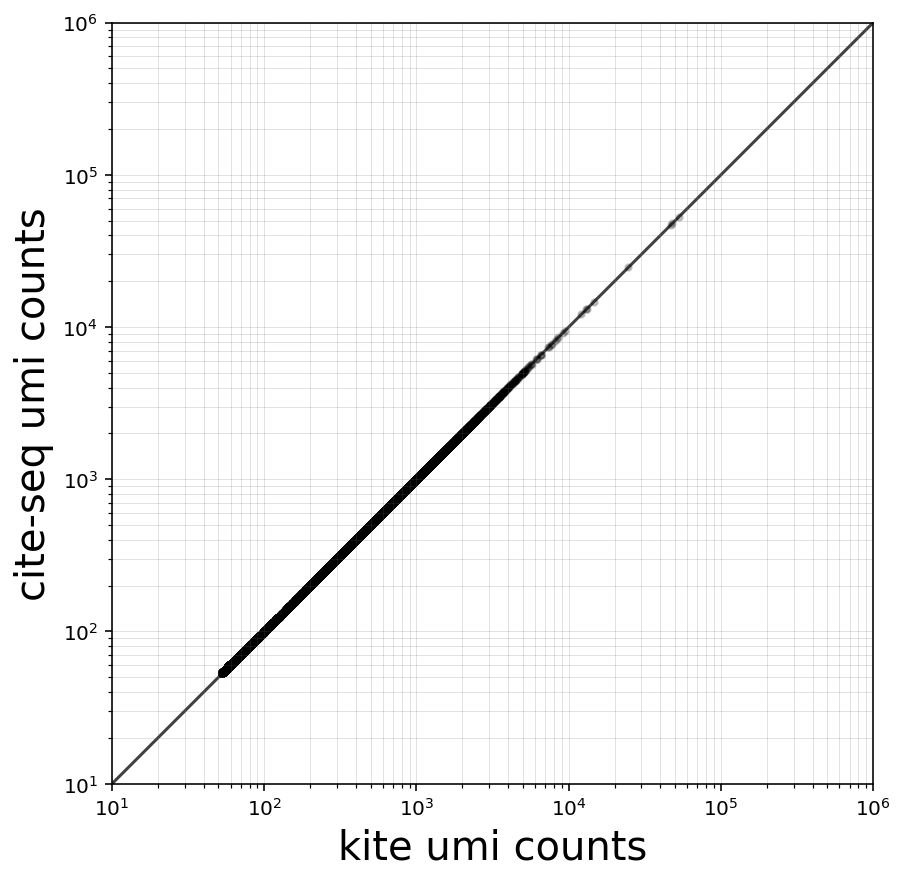

In [75]:
# fig, ax = plt.subplots(figsize=(7*3, 7), ncols=3)
fig, ax = plt.subplots(figsize=(7*1, 7), ncols=1)

plot_bulk(kite_bulk, cite_bulk, xlabel="kite umi counts", ylabel="cite-seq umi counts", ax=ax)
#plot_bulk(kite_bulk, cr_bulk, xlabel="kite umi counts", ylabel="cell ranger umi counts", ax=ax[1])
#plot_bulk(cr_bulk, cite_bulk, xlabel="cell ranger umi counts", ylabel="cite-seq umi counts", ax=ax[2])

plt.show()

In [76]:
print("r-squared values\n--")
slope, intercept, r_value, p_value, std_err = stats.linregress(kite_bulk, cite_bulk)
print("kite & cite-seq:\t", r_value**2)

# slope, intercept, r_value, p_value, std_err = stats.linregress(kite_bulk, cr_bulk)
# print("kite & cell ranger:\t", r_value**2)
# 
# slope, intercept, r_value, p_value, std_err = stats.linregress(cr_bulk, cite_bulk)
# print("cell ranger & cite:\t", r_value**2)

r-squared values
--
kite & cite-seq:	 0.9999962462846305


## Pearson correlation on barcodes

In [77]:
corr_1 = sparse_M_corr(kite[common_bcs].X.T, cite[common_bcs].X.T)
# corr_2 = sparse_M_corr(kite[common_bcs].X.T, cr[common_bcs].X.T)
# corr_3 = sparse_M_corr(cr[common_bcs].X.T, cite[common_bcs].X.T)

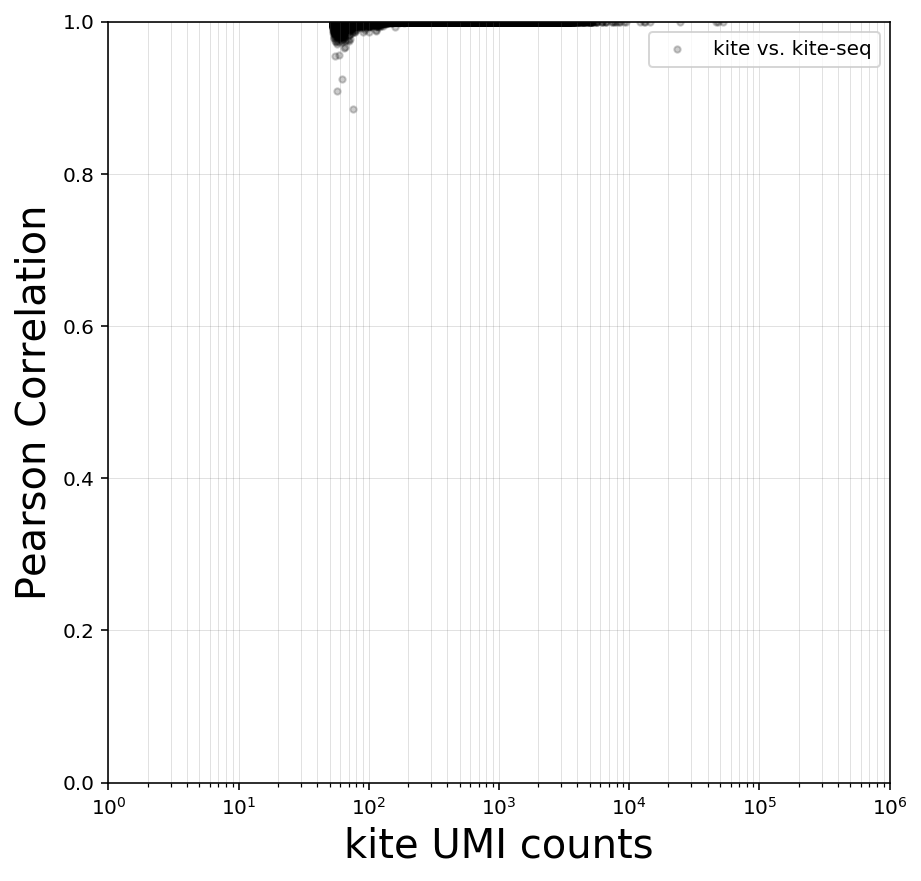

In [79]:
# fig, ax = plt.subplots(figsize=(7*3, 7), ncols=3)
fig, ax = plt.subplots(figsize=(7*1, 7), ncols=1)

corr_plot(kite[common_bcs].obs["counts"].values, corr_1, ax=ax, xlabel="kite UMI counts", leg=["kite", "kite-seq"])
# corr_plot(kite[common_bcs].obs["counts"].values, corr_2, ax=ax[1], xlabel="kite UMI counts", leg=["kite", "cell ranger"])
# corr_plot(cr[common_bcs].obs["counts"].values, corr_3, ax=ax[2], xlabel="cell ranger UMI counts", leg=["cell ranger", "cite-seq"])
# 
plt.legend()
plt.show()

# Clustering Analysis

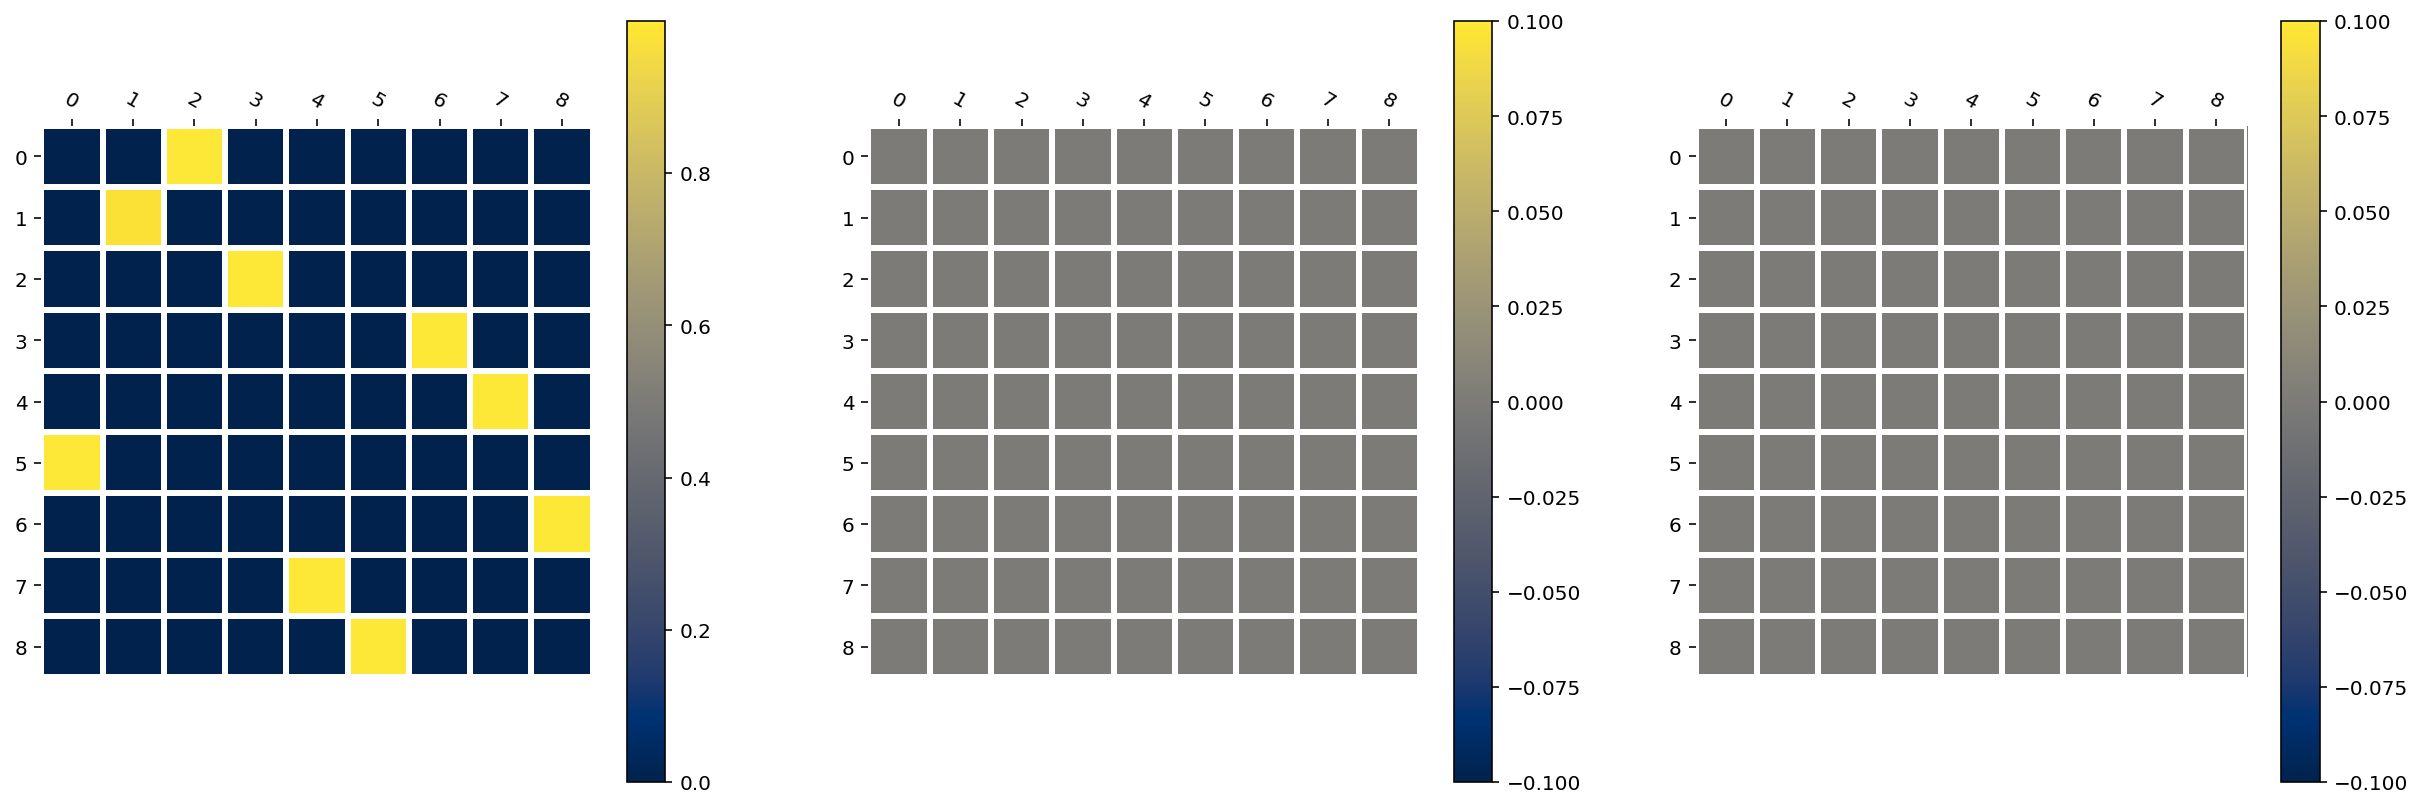

In [83]:
fig, ax = plt.subplots(figsize=(7*3,7), ncols=3)
heatmap(jaccard_1, kite_clusters, cite_clusters, ax=ax[0], cmap="cividis")
heatmap(jaccard_2, kite_clusters, cite_clusters, ax=ax[1], cmap="cividis")
heatmap(jaccard_3, kite_clusters, cite_clusters, ax=ax[2], cmap="cividis")
plt.show()

## Per cluster correlations

In [111]:
cluster_corr = []
cluster_size = []
for idx, cluster in enumerate(np.argmax(jaccard_1, axis=0)):
    a = kite[kite.obs.kmeans == idx]
    b = cite[cite.obs.kmeans == cluster]
    
    bcs = [a.obs.index.values, b.obs.index.values]
    
    common = np.sort(np.array(list(set.intersection(*map(set,bcs)))))
    
    cluster_corr.append(sparse_M_corr(a[common].X.T, b[common].X.T))
    
    cluster_size.append(common.shape[0])

In [118]:
variance = [i.var() for i in cluster_corr]

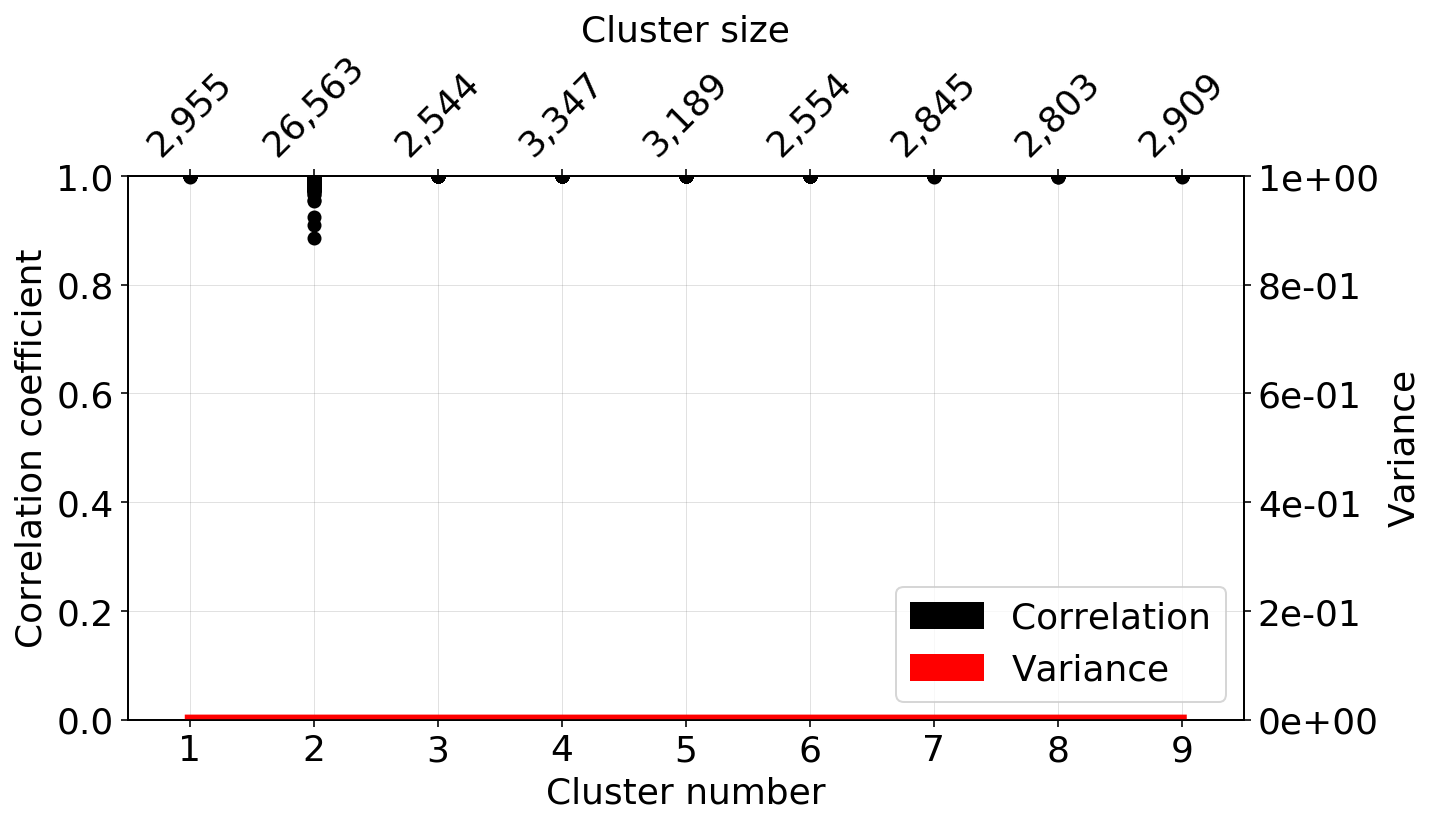

In [160]:
fig, ax = plt.subplots(figsize = (10, 5))
ax.boxplot(cluster_corr, sym='black')
ax.set_ylim(0,1)
ax.set_ylabel("Correlation coefficient")
ax.set_xlabel("Cluster number")
ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = 0.2)


new_tick_locations = np.arange(1, samples+2)
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(cluster_size)
ax2.set_xticklabels(['{:,}'.format(int(x)) for x in cluster_size])
ax2.xaxis.set_tick_params(rotation=45)



ax2.set_xlabel("Cluster size")

ax3 = ax.twinx()
ax3.plot(new_tick_locations, variance, color="red", linewidth=5)
ax3.set_ylim(0, 1)
ax3.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0e'))
ax3.set_ylabel("Variance")

black_dot = mpatches.Patch(color='black', label='Correlation')
red_line = mpatches.Patch(color='red', label='Variance')
plt.legend(handles=[black_dot, red_line], loc="lower right")

plt.show()